In [107]:
#!pip install --user dowhy
#!pip install econml
#!pip install --user causalml

In [108]:
import sys
sys.path.append('..')
from economic_brazil.coleta_dados.economic_data_brazil import data_economic
from economic_brazil.processando_dados.divisao_treino_teste import treino_teste_seies_temporal, treino_test_dados
#!pip install --user dowhy
import dowhy
from dowhy import CausalModel
from causalml.inference.meta import LRSRegressor
from econml.dml import LinearDML
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f8ad1dc2d40>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/threadpoolctl.py", line 1014, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/codespace/.local/lib/python3.10/site-packages/threadpoolctl.py", line 1184, in _make_controller_from_path
    lib_controller = controller_class(
  File "/home/codespace/.local/lib/python3.10/site-packages/threadpoolctl.py", line 113, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/home/codespace/.python/current/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /home/codespace/.local/lib/python3.10/site-packages/scipy.libs/libopenblasp-r0-24bff013.3.26.dev.so: cannot open shared object file: No such file or directory

In [4]:
dados = data_economic()

Erro ao buscar dados Expected object or value
Problema na importação dos dados do Banco Central.Arquivo selecionado da memoria com a ultima data sendo 2024-05-01 00:00:00.


In [8]:
dados

,selic,IPCA-EX2,IPCA-EX3,IPCA-MS,IPCA-MA,IPCA-EX0,IPCA-EX1,IPCA-DP,expectativas_inflacao,meta_inflacao,inflacao_efetiva,diferenca_meta_efetiva,ipca,pib,despesas_publica,capital_fixo,producao_industrial_manufatureira
Date,,,,,,,,,,,,,,,,,
2000-01-01,18.94,0.42,0.33,0.48,0.35,0.56,0.63,0.47,0.522857,6.0,5.97,0.03,0.62,4.4,3.6,-0.3,51.67275
2000-02-01,18.87,0.17,0.21,0.44,0.35,0.45,0.32,0.32,0.531897,6.0,5.97,0.03,0.13,4.4,3.6,-0.3,51.67275
2000-03-01,18.85,-0.11,-0.03,0.37,0.35,0.05,0.16,0.21,0.593452,6.0,5.97,0.03,0.22,4.4,3.6,-0.3,51.67275
2000-04-01,18.62,0.16,0.22,0.45,0.35,0.87,0.62,0.60,0.587363,6.0,5.97,0.03,0.42,4.0,1.3,3.9,51.67275
2000-05-01,18.51,0.12,0.16,0.35,0.35,0.20,0.19,0.18,0.562051,6.0,5.97,0.03,0.01,4.0,1.3,3.9,51.67275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01,11.65,0.59,0.61,0.51,0.37,0.16,0.22,0.45,0.308143,3.0,4.62,-1.37,0.42,2.1,3.0,-4.4,84.26269
2024-02-01,11.15,0.30,0.28,0.42,0.48,0.73,0.61,0.53,0.307386,3.0,4.62,-1.37,0.83,2.1,3.0,-4.4,84.26269
2024-03-01,11.00,0.25,0.21,0.24,0.15,0.01,0.10,0.16,0.294226,3.0,4.62,-1.37,0.16,2.1,3.0,-4.4,84.26269


In [10]:
x_train, y_train, x_test, y_test = treino_test_dados(dados, data_divisao="2020-04-01",coluna='selic')

O tamanho do y_treino e  (243,)
O tamanho do x_treino e  (243, 16)
--------------------
O tamanho do y_teste e  (50,)
O tamanho do x_teste e  (50, 16)
--------------------


In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((243, 16), (243,), (50, 16), (50,))

# Deteccão de Causalidade com dowhy

In [19]:
# Modelo causal
model = CausalModel(
    data=dados.reset_index(),
    treatment='inflacao_efetiva',
    outcome='selic',
    common_causes=['IPCA-EX2', 'IPCA-EX3', 'IPCA-MS', 'IPCA-MA', 'IPCA-EX0', 'IPCA-EX1', 'IPCA-DP', 'expectativas_inflacao', 'meta_inflacao', 'diferenca_meta_efetiva', 'ipca', 'pib', 'despesas_publica', 'capital_fixo', 'producao_industrial_manufatureira']
)

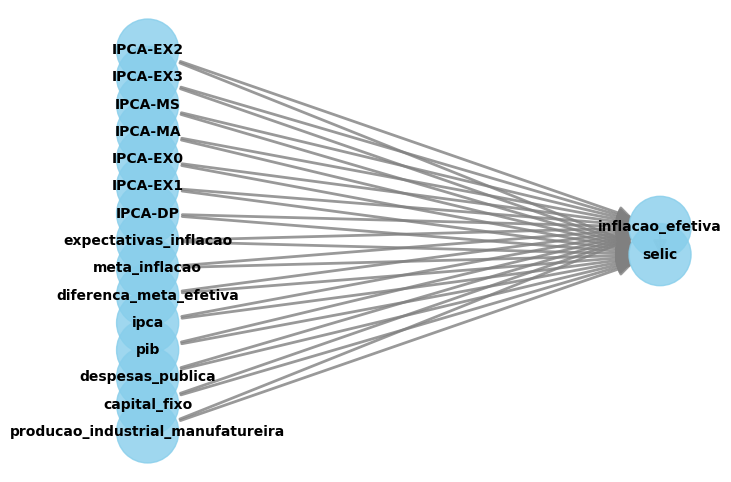

In [20]:
model.view_model()

In [22]:
# Identificação
identified_estimand = model.identify_effect()
# Estimação do efeito causal
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                                                    
───────────────────(E[selic|IPCA-EX0,expectativas_inflacao,pib,ipca,IPCA-DP,de
d[inflacao_efetiva]                                                           

                                                                              
spesas_publica,IPCA-EX2,IPCA-EX3,IPCA-MS,meta_inflacao,capital_fixo,IPCA-MA,pr
                                                                              

                                                                 
oducao_industrial_manufatureira,diferenca_meta_efetiva,IPCA-EX1])
                                                                 
Estimand assumption 1, Unconfoundedness: If U→{inflacao_efetiva} and U→selic then P(selic|inflacao_efetiva,IPCA-EX0,expectativas_inflacao,pib,ipca,IPCA-DP,despesas_publi

In [23]:
refute = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute)

Refute: Use a Placebo Treatment
Estimated effect:2.0809721340937064
New effect:-3.197442310920451e-14
p value:0.0



In [91]:
def estimate_effect_no_common_causes(data, treatment_var, outcome_var):
    # Criar o modelo causal sem variáveis de confusão
    model = CausalModel(
        data=data.reset_index(),
        treatment=treatment_var,
        outcome=outcome_var,
        common_causes=[]
    )
    
    # Identificação do estimand
    identified_estimand = model.identify_effect()
    
    # Estimação do efeito causal
    estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
    
    # Validação do efeito causal
    refute = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
    
    return estimate, refute
variables_of_interest = ['inflacao_efetiva', 'pib', 'IPCA-EX2', 'IPCA-EX3', 'IPCA-MS', 'IPCA-MA', 
                         'IPCA-EX0', 'IPCA-EX1', 'IPCA-DP', 'expectativas_inflacao', 'meta_inflacao', 
                         'diferenca_meta_efetiva', 'ipca', 'despesas_publica', 'capital_fixo', 
                         'producao_industrial_manufatureira']
variaveis = []
estimate_value = []
interpretacao = []
intervalos = []
for var in variables_of_interest:
    estimate, refute = estimate_effect_no_common_causes(dados, var, 'selic')
    variaveis.append(f'selic_{var}')
    estimate_value.append(estimate.value)
    intervalos.append(estimate.get_confidence_intervals())
    interpretacao.append(estimate.interpret())
data_relacao = pd.DataFrame({'variaveis': variaveis, 'estimate_value': estimate_value,'intervalos': intervalos,'interpretacao': interpretacao}).sort_values(by='estimate_value', ascending=False)  
data_relacao
    

Increasing the treatment variable(s) [inflacao_efetiva] from 0 to 1 causes an increase of 0.7601345851798209 in the expected value of the outcome [['selic']], over the data distribution/population represented by the dataset.
Increasing the treatment variable(s) [pib] from 0 to 1 causes an increase of 0.11859897891086746 in the expected value of the outcome [['selic']], over the data distribution/population represented by the dataset.
Increasing the treatment variable(s) [IPCA-EX2] from 0 to 1 causes an increase of 4.676758974984322 in the expected value of the outcome [['selic']], over the data distribution/population represented by the dataset.
Increasing the treatment variable(s) [IPCA-EX3] from 0 to 1 causes an increase of 5.369464395893903 in the expected value of the outcome [['selic']], over the data distribution/population represented by the dataset.
Increasing the treatment variable(s) [IPCA-MS] from 0 to 1 causes an increase of 12.250201533770042 in the expected value of the o

,variaveis,estimate_value,intervalos,interpretacao
9,selic_expectativas_inflacao,30.150141,"[[25.52248941227828, 34.777791634541025]]",None
4,selic_IPCA-MS,12.250202,"[[9.882862803816671, 14.617540263723413]]",None
8,selic_IPCA-DP,7.386701,"[[5.294060304809893, 9.47934168813458]]",None
5,selic_IPCA-MA,7.319976,"[[4.868794122426034, 9.771157900963757]]",None
7,selic_IPCA-EX1,7.104718,"[[5.227972112642551, 8.981463733066802]]",None
3,selic_IPCA-EX3,5.369464,"[[3.252574475342079, 7.486354316445734]]",None
2,selic_IPCA-EX2,4.676759,"[[2.7021261377251693, 6.651391812243469]]",None
6,selic_IPCA-EX0,4.583607,"[[2.5729566786821554, 6.594256814963696]]",None
12,selic_ipca,2.365684,"[[0.9305107731071862, 3.8008574494918133]]",None
10,selic_meta_inflacao,1.416792,"[[0.9114971216530394, 1.9220871782120041]]",None


# Deteccão de Causalidade com econml

In [103]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor

def estimate_effect_econml(data, treatment_var, outcome_var):
    X = data.drop(columns=[treatment_var, outcome_var])
    T = data[treatment_var]
    Y = data[outcome_var]

    est = LinearDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor())
    est.fit(Y, T, X=X)
    
    treatment_effect = est.const_marginal_effect(X).mean()
    
    return treatment_effect

# Suponha que 'dados' seja o DataFrame contendo suas variáveis
outcome_var = 'selic'
variables_of_interest = dados.columns.drop('selic')

results_econml = []

for var in variables_of_interest:
    treatment_effect = estimate_effect_econml(dados, var, outcome_var)
    results_econml.append({
        'variavel': var,
        'estimate_value': treatment_effect
    })

results_econml_df = pd.DataFrame(results_econml)
results_econml_df = results_econml_df.sort_values(by='estimate_value', ascending=False)
results_econml_df


                             variavel  estimate_value
7               expectativas_inflacao       13.078000
2                             IPCA-MS        6.126566
10             diferenca_meta_efetiva        4.384876
1                            IPCA-EX3        4.225117
5                            IPCA-EX1        1.512644
12                                pib        0.440795
13                   despesas_publica        0.230922
4                            IPCA-EX0        0.021998
14                       capital_fixo       -0.034091
15  producao_industrial_manufatureira       -0.073447
8                       meta_inflacao       -0.698264
11                               ipca       -1.016674
6                             IPCA-DP       -2.570366
9                    inflacao_efetiva       -2.610367
3                             IPCA-MA       -3.651648
0                            IPCA-EX2       -4.060942


# Deteccão de Causalidade com CausalML